# Process NEON hyperspectral ancillary images across a site, year
Create tile stacks for a site, year  
Build VRTs of all tiles stacks for a site, year

In [5]:
import numpy as np
import h5py
import osgeo
from osgeo import gdal, osr
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob
from glob import glob
import sys, os
sys.path.append('/home/pmontesa/code/icesat2_boreal/lib')
import rasterio as rio 
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
SITE = 'MLBS'
YEAR = 2017

In [85]:
maindir = '/explore/nobackup/projects/ilab/data/AGB/Airborne_Hyperspectral/DP3.30006.001/neon-aop-products'
search_path = f'/{YEAR}/FullSite/D*/{YEAR}_{SITE}_*/L3/Spectrometer/Reflectance/*.h5'
outdir = f'/explore/nobackup/projects/ilab/data/AGB/test/hyper_ancillary_stacks/{SITE}/{YEAR}'
!mkdir -p $outdir
h5_fn_list = glob(maindir + search_path)
print(f'# tiles for {SITE} in {YEAR}: {len(h5_fn_list)}')

# tiles for MLBS in 2017: 162


#### for each tile, create an Ancillary Imagery stacked tif

In [142]:
from rasterio.transform import from_origin
from rasterio.profiles import DefaultGTiffProfile
list_imagery = ['Aerosol_Optical_Depth','Aspect','Cast_Shadow',
                                            'Dark_Dense_Vegetation_Classification','Data_Selection_Index',
                                            'Haze_Cloud_Water_Map','Illumination_Factor','Path_Length',
                                            'Sky_View_Factor','Slope','Smooth_Surface_Elevation','Visibility_Index_Map',
                                            'Water_Vapor_Column','Weather_Quality_Indicator']
def stack_ancillary_imagery(fn, SITE, outdir=outdir, 
                            list_imagery = list_imagery
                           ):
    
    out_fn = os.path.join(outdir, os.path.basename(fn).replace('.h5','_ancillary.tif'))
    
    f = h5py.File(fn,'r')
    
    SITE_refl = f[SITE]['Reflectance']
    
    prj4 = SITE_refl['Metadata']['Coordinate_System']['Proj4']
    epsg = SITE_refl['Metadata']['Coordinate_System']["EPSG Code"]
    prj4_str = prj4[()].decode("utf-8")
    epsg_str = epsg[()].decode("utf-8")
    
    mapInfo = SITE_refl['Metadata']['Coordinate_System']['Map_Info']
    mapInfo_split  = str(mapInfo[()]).split(',')
    
    #Extract the resolution & convert to floating decimal number
    res = float(mapInfo_split[5]),float(mapInfo_split[6])
    #print('Resolution:',res)

    #Extract the upper left-hand corner coordinates from mapInfo
    xMin = float(mapInfo_split[3]) 
    yMax = float(mapInfo_split[4])
    
    
    arr_list = []
    bandnames_list = []
    for n, img in enumerate(list_imagery):
        #print(f'img n = {n}')
        
        arr = SITE_refl['Metadata/Ancillary_Imagery'][img]
        #arr = np.moveaxis(SITE_refl['Metadata/Ancillary_Imagery'][img], -1, 0)

        if len(arr.shape) == 2:
            arr = np.expand_dims(arr, 2)
            
        print(f'{arr.shape}:\t\t{img}')
        
        # Append each band of array to array list: most arrays have only 1 band
        for i in range(0, arr.shape[2]):
            #print(f'arr i = {i}')
            arr_list.append(arr[:,:,i])
            
            bname = img
            if i > 0:
                bname = img + '_' +str(i + 1)
            bandnames_list.append(bname)
    
    # After arrays are re-configured...    
    # Calculate the xMax and yMin values from the dimensions
    # xMax = left corner + (# of columns * resolution)
    xMax = xMin + (arr.shape[2]*res[0])
    yMin = yMax - (arr.shape[1]*res[1]) 
    tile_ext = (xMin, xMax, yMin, yMax)
    #Can also create a dictionary of extent:
    tile_extDict = {}
    tile_extDict['xMin'] = xMin
    tile_extDict['xMax'] = xMax
    tile_extDict['yMin'] = yMin
    tile_extDict['yMax'] = yMax
    #print(fn)
    print(tile_extDict)
    # Create the stacked array
    stack = np.stack( arr_list, axis=0 )
    print(f'Stack shape: {stack.shape}')
    
    #origin is upper left
    transform = from_origin(tile_extDict['xMin'], tile_extDict['yMax'], res[0], res[1])

    # Set the profile for the output raster based on the ndarray stack
    out_profile = DefaultGTiffProfile(
        descriptions=bandnames_list,
        #interleave='pixel',
        driver="GTiff",
        height=stack.shape[1],
        width=stack.shape[2],
        count=stack.shape[0],
        dtype='float32',#str(stack.dtype),
        crs=CRS.from_epsg(epsg_str),
        resolution=res,
        transform=transform,
        #nodata=np.nan
    )
    print(out_profile)
    print(out_fn)
    with rio.open(out_fn, 'w+', **out_profile) as new_dataset:
        new_dataset.write(stack)
        #new_dataset.close()
    return stack, bandnames_list

In [143]:
stack, bandnames_list = stack_ancillary_imagery(h5_fn_list[5], SITE)

(1000, 1000, 1):		Aerosol_Optical_Depth
(1000, 1000, 1):		Aspect
(1000, 1000, 1):		Cast_Shadow
(1000, 1000, 1):		Dark_Dense_Vegetation_Classification
(1000, 1000, 1):		Data_Selection_Index
(1000, 1000, 1):		Haze_Cloud_Water_Map
(1000, 1000, 1):		Illumination_Factor
(1000, 1000, 1):		Path_Length
(1000, 1000, 1):		Sky_View_Factor
(1000, 1000, 1):		Slope
(1000, 1000, 1):		Smooth_Surface_Elevation
(1000, 1000, 1):		Visibility_Index_Map
(1000, 1000, 1):		Water_Vapor_Column
(1000, 1000, 3):		Weather_Quality_Indicator
{'xMin': 542000.0, 'xMax': 542003.0, 'yMin': 4133000.0, 'yMax': 4134000.0}
Stack shape: (16, 1000, 1000)
{'driver': 'GTiff', 'interleave': 'band', 'tiled': True, 'blockxsize': 256, 'blockysize': 256, 'compress': 'lzw', 'nodata': 0, 'dtype': 'float32', 'descriptions': ['Aerosol_Optical_Depth', 'Aspect', 'Cast_Shadow', 'Dark_Dense_Vegetation_Classification', 'Data_Selection_Index', 'Haze_Cloud_Water_Map', 'Illumination_Factor', 'Path_Length', 'Sky_View_Factor', 'Slope', 'Smooth_Su

### Visual smry of ancilarry imagery

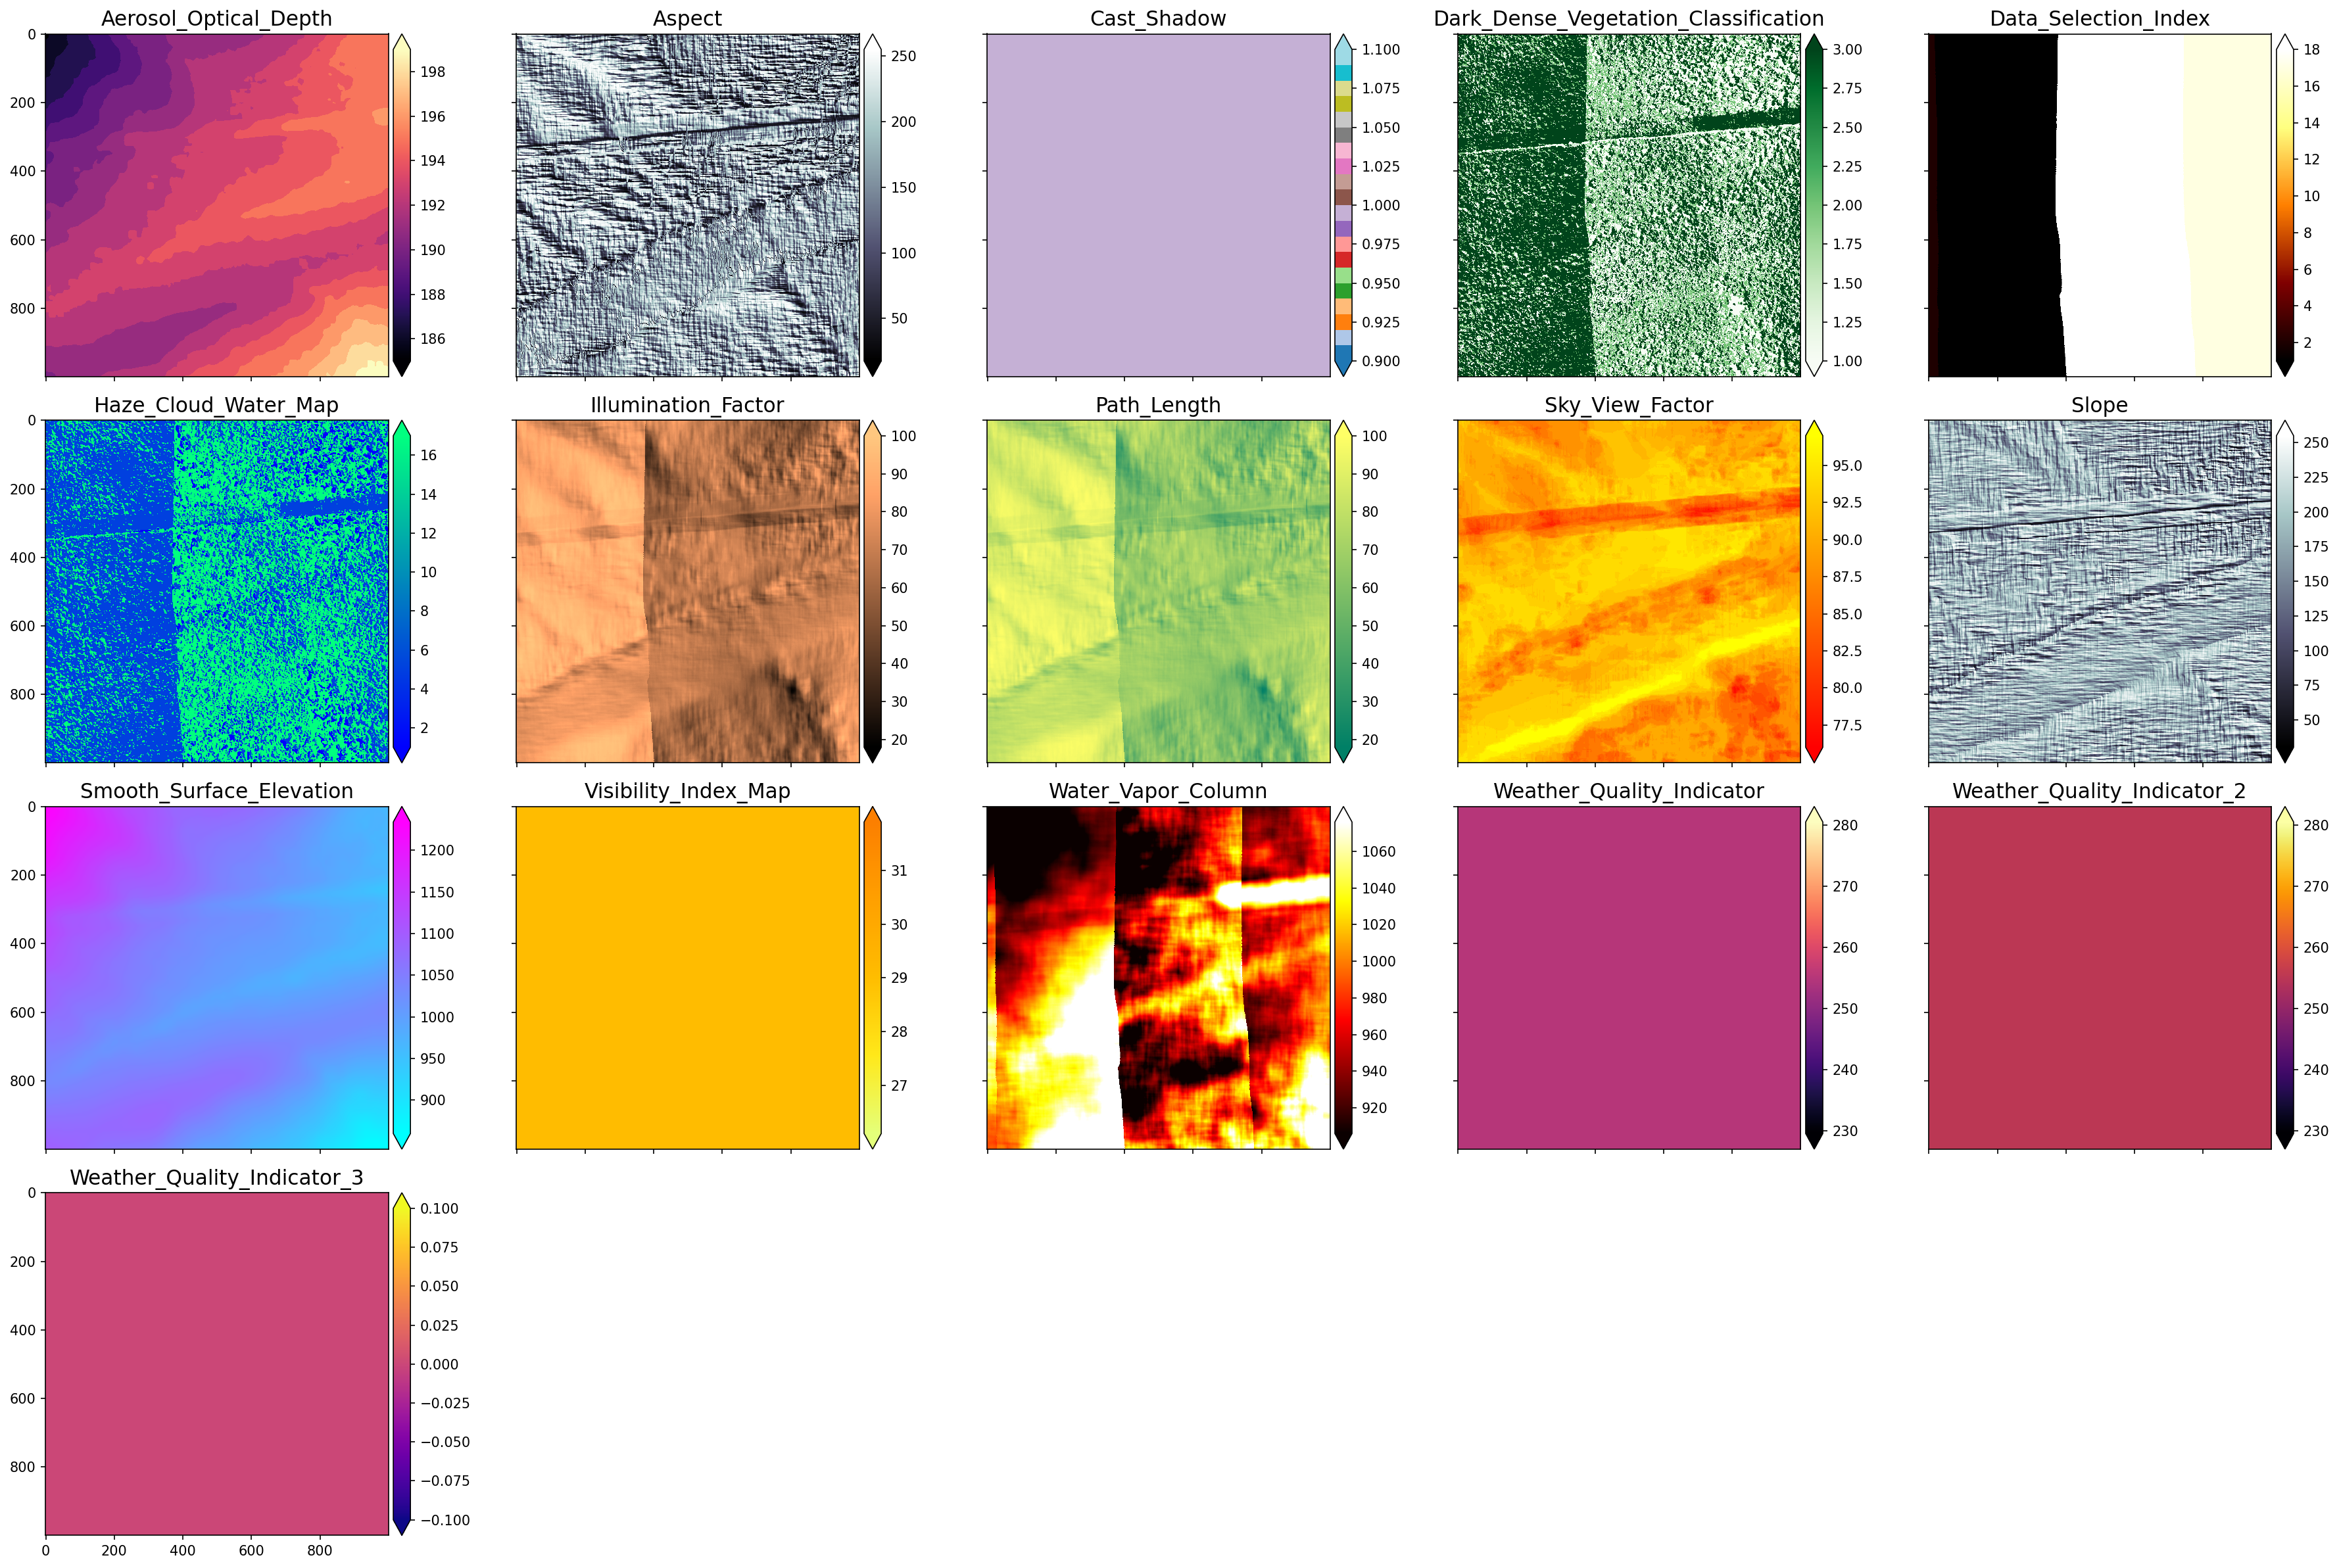

In [147]:
cmap_list = ['magma', 'bone', 'tab20',  'Greens', 'afmhot', 'winter',
             'copper', 'summer', 'autumn', 'bone', 'cool', 'Wistia',
             'hot', 'magma', 'inferno', 'plasma'
            ]

f, axa = plt.subplots(nrows=4, ncols=5, sharex=True, sharey=True, dpi=150, figsize=(24,16)) 
for n, ax in enumerate(axa.ravel()):
    #arr = SITE_refl['Metadata/Ancillary_Imagery'][list_imagery[n]]
    #print(f'{list_imagery[n]}:\t\t\t\t\t{arr.shape}')
    
    # This makes leftover axes empty and doesnt return an error
    if n >= len(bandnames_list):
        ax.axis('off')
    if n >= len(bandnames_list):
        pass
    else:
        ma = stack[n,:,:]
        #print(f'{list_imagery[n]}:\t\t\t\t\t{ma.shape}')
        
        # Hillshade
        if 'Aspect' in bandnames_list[n] or 'Slope' in bandnames_list[n]:
            from localtileserver import examples, helpers
            ma = helpers.hillshade(ma)
        if n < 11:
            im = ax.imshow(ma, interpolation='none', cmap=cmap_list[n])
        else:
            im = ax.imshow(ma, interpolation='none', cmap=cmap_list[n], clim=(np.nanpercentile(ma,10), np.nanpercentile(ma,90)) )
        #ax.set_title(layer_names[n] + '\n' + os.path.splitext(os.path.basename(fn_list[n]))[0], fontsize=5)
        ax.set_title(bandnames_list[n], fontsize=15)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb = f.colorbar(im, cax=cax, orientation='vertical', extend='both')
        #cb.set_label(label_list[n])
        
#fig.suptitle(f'Site {SITE} for year {YEAR}\n{DIR_SITE_EXTENT}', fontsize=16)
plt.tight_layout()

In [77]:
f = '/explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2015_541567.6_4136443.0_542567.6_4137443.0/hyper-D07-2015.tif'
with rio.open(f, 'r') as h_ds:
    print(h_ds.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1000, 'height': 1000, 'count': 21, 'crs': CRS.from_epsg(32617), 'transform': Affine(1.0, 0.0, 541567.0,
       0.0, -1.0, 4137443.0), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'pixel'}


In [108]:

fn = h5_fn_list[5]

In [ ]:
f = h5py.File(fn,'r')